#  Here we read the Data file, we remove the attribute type and prepare the dataset.

In [1]:
# Set up imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [2]:
def make_output(letter):
    """Convert a capital letter into the a binary expression
       to be used as output of the NN"""
    output= [ float(c) for c in "{:05b}".format(ord(letter)-65) ]
    return output

# Read OCR dataset
dataset = pd.read_csv("letter-recognition.txt", header=None).values

# Generate output
output= np.array([ make_output(c) for c in dataset[:,0] ])

# Stack output to data
# dataset= np.hstack( (dataset,output) )

# Delete first column (letter)
dataset= np.delete(dataset,0,1) 

# Convert to float (required by tensorflow)
dataset= dataset.astype(float)

# Using Pair plot we provided the 2D plots for different classes of the data, paired together. 
(Remember WEKA, we choose every possible pair of dimensions of data to see the distributions)

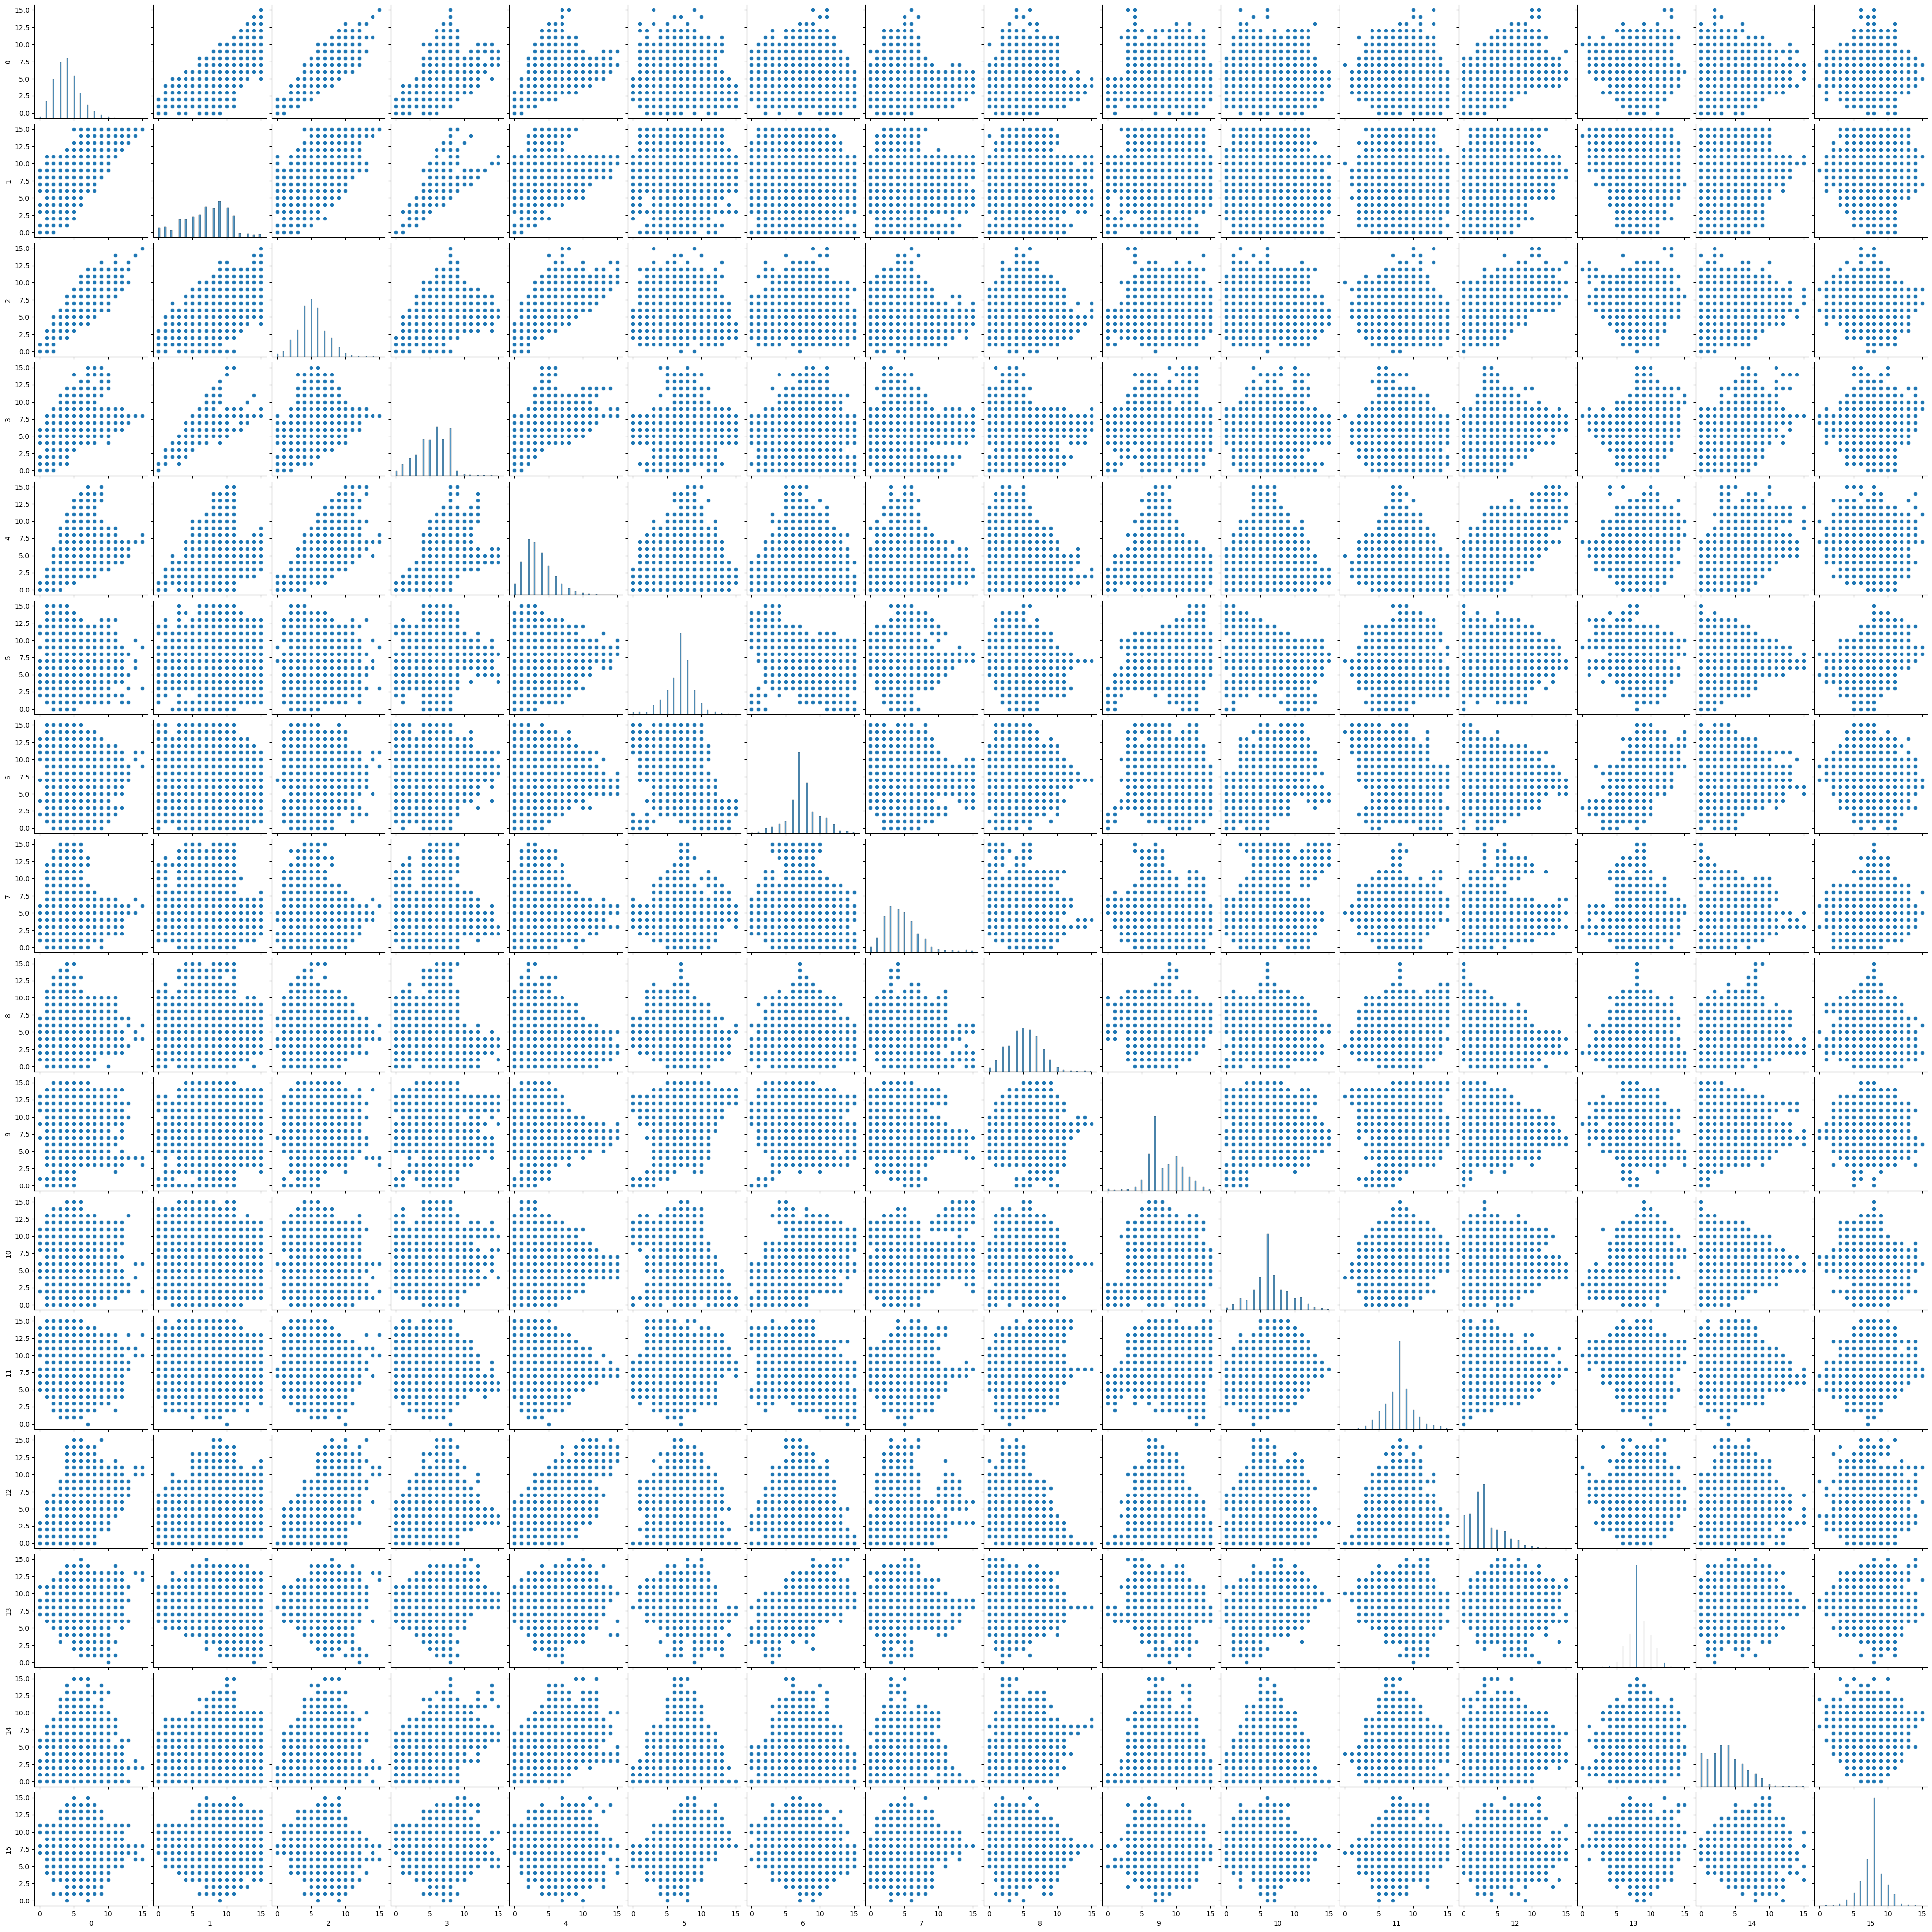

In [3]:
# Create a pairplot
df = pd.DataFrame(dataset)
sns.pairplot(df)
p= plt.show()

# Splitting the data into two portions. We choose 70 % to be used for training and 30 % for Testing.

In [4]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(dataset, output, 
                                                test_size=0.3, 
                                                random_state=2)

print("Training dataset size: ", len(trainX))
print("Test dataset size: ", len(testX))

Training dataset size:  14000
Test dataset size:  6000


# Building the Neural Network : 
The configuration :
# 1_ 16 Input nodes
 #  2_ 3 Hidden Layers : Rectifier Activation Functions ; Fully connected to previous layer's inputs
 # Keras Sequential model : Automatic Fitting
# 3_ 5 nodes in output layer : Sigmoid Activation Function

In [6]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

np.random.seed(10)
my_NN = Sequential() # create model

# First layer, set the input_dim to the number of features
my_NN.add(Dense(40, input_dim=16, activation='relu')) # hidden layer

# More hidden layers
my_NN.add(Dense(60, activation='relu')) # hidden layer
my_NN.add(Dense(60, activation='relu')) # hidden layer

# Output layer
my_NN.add(Dense(5, activation='sigmoid')) # output layer

# Compile and define the loss function
my_NN.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# We train the neural network here, for classification.
We've chosen 400 batched each containing 100 epochs for training.

In [6]:
train_loss= []
train_acc= []
test_loss= []
test_acc= []

# Iterate for batches of epochs and collect status for train and test
for step in range(400):
    if step%10==0:
        print("Batch ",step)
    
    # verbose=0 suppresses the file writing message
    my_NN_fitted = my_NN.fit(trainX, trainy, epochs=100, 
                             verbose=0, batch_size=trainX.shape[0])
    
    # Collect performance information for train and test
    perf= my_NN.evaluate(trainX, trainy, verbose=0)
    train_loss.append(perf[0])
    train_acc.append(perf[1])
    
    perf= my_NN.evaluate(testX, testy, verbose=0)
    test_loss.append(perf[0])
    test_acc.append(perf[1])

Batch  0
Batch  10
Batch  20
Batch  30
Batch  40
Batch  50
Batch  60
Batch  70
Batch  80
Batch  90
Batch  100
Batch  110
Batch  120
Batch  130
Batch  140
Batch  150
Batch  160
Batch  170
Batch  180
Batch  190
Batch  200
Batch  210
Batch  220
Batch  230
Batch  240
Batch  250
Batch  260
Batch  270
Batch  280
Batch  290
Batch  300
Batch  310
Batch  320
Batch  330
Batch  340
Batch  350
Batch  360
Batch  370
Batch  380
Batch  390


# Provided the Plot of Loss and Accuracy which apparently after 2500 epochs the train set and the test set start to converge somehow.

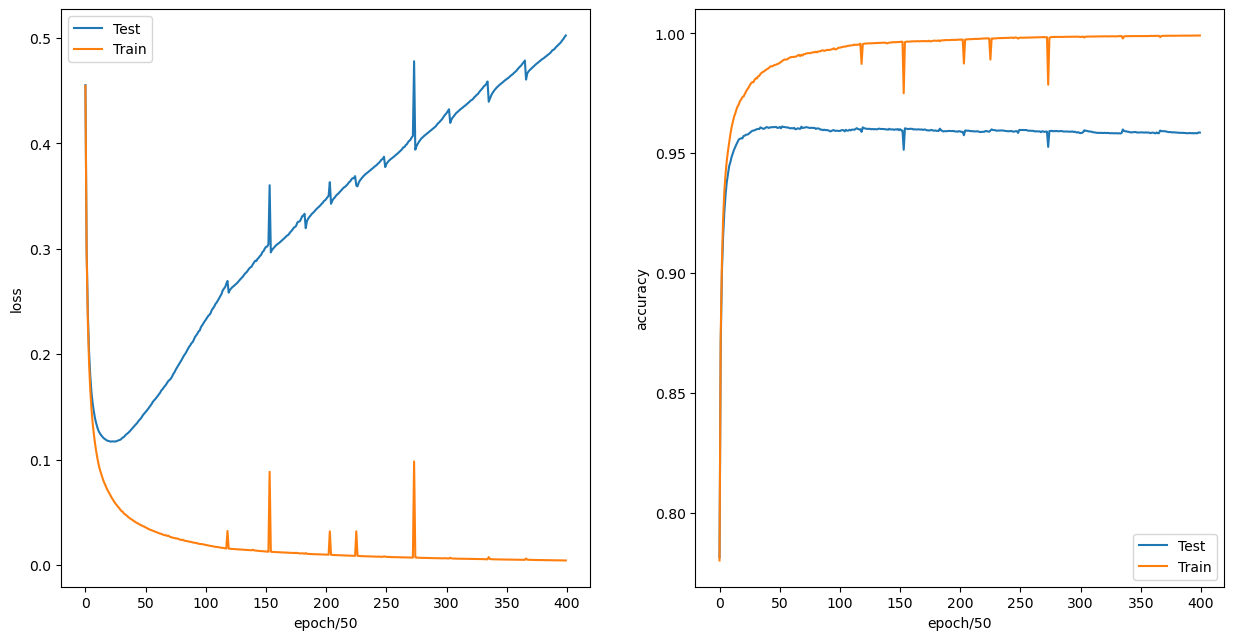

In [7]:
fig = plt.figure(frameon=False)
fig.set_size_inches(15,7.5)

# loss
plt.subplot(1,2,1)
plt.xlabel("epoch/50")
plt.ylabel("loss")
plt.plot(test_loss, label="Test")
plt.plot(train_loss, label="Train")
plt.legend()

# accuracy
plt.subplot(1,2,2)
plt.xlabel("epoch/50")
plt.ylabel("accuracy")
plt.plot(test_acc, label="Test")
plt.plot(train_acc, label="Train")
plt.legend()

p= plt.show()

# Here we measure the accuracy of the performance of the Neural Network. We see that almost 81 % of test dataset's performance validates the cross-checking with training dataset's objective by Fitting.

In [8]:
# Predict output for test dataset
NN_out= my_NN.predict(testX, verbose=0)

# Function to decode output
def to_letter_code(bin_out):
    """Convert binary encoding output into a letter code"""
    rounded= ""
    for val in bin_out:
        rounded= rounded+str(int(round(val)))
    
#     return chr(int(rounded,2)+65)
    return int(rounded,2)
    
total= 0
correct= 0
for req,pred in zip(testy,NN_out):
    if to_letter_code(req)==to_letter_code(pred):
        correct+=1
    total+=1

print("Total:  ", total)
print("Correct: {:d} ({:.2f}%)".format(correct,100.*correct/total))


Total:   6000
Correct: 5166 (86.10%)


# The provided Confusion matrix gives a better overview on the NN's accuracy.
 One can easily see that for each attributing class what portion of data passes cross-checking and then also you can see the detailed failed fittings; and how the fitting went wrong between different class of attributes. 
 
 Also, noteworthy to mention the neural network avoids Over-Fitting.

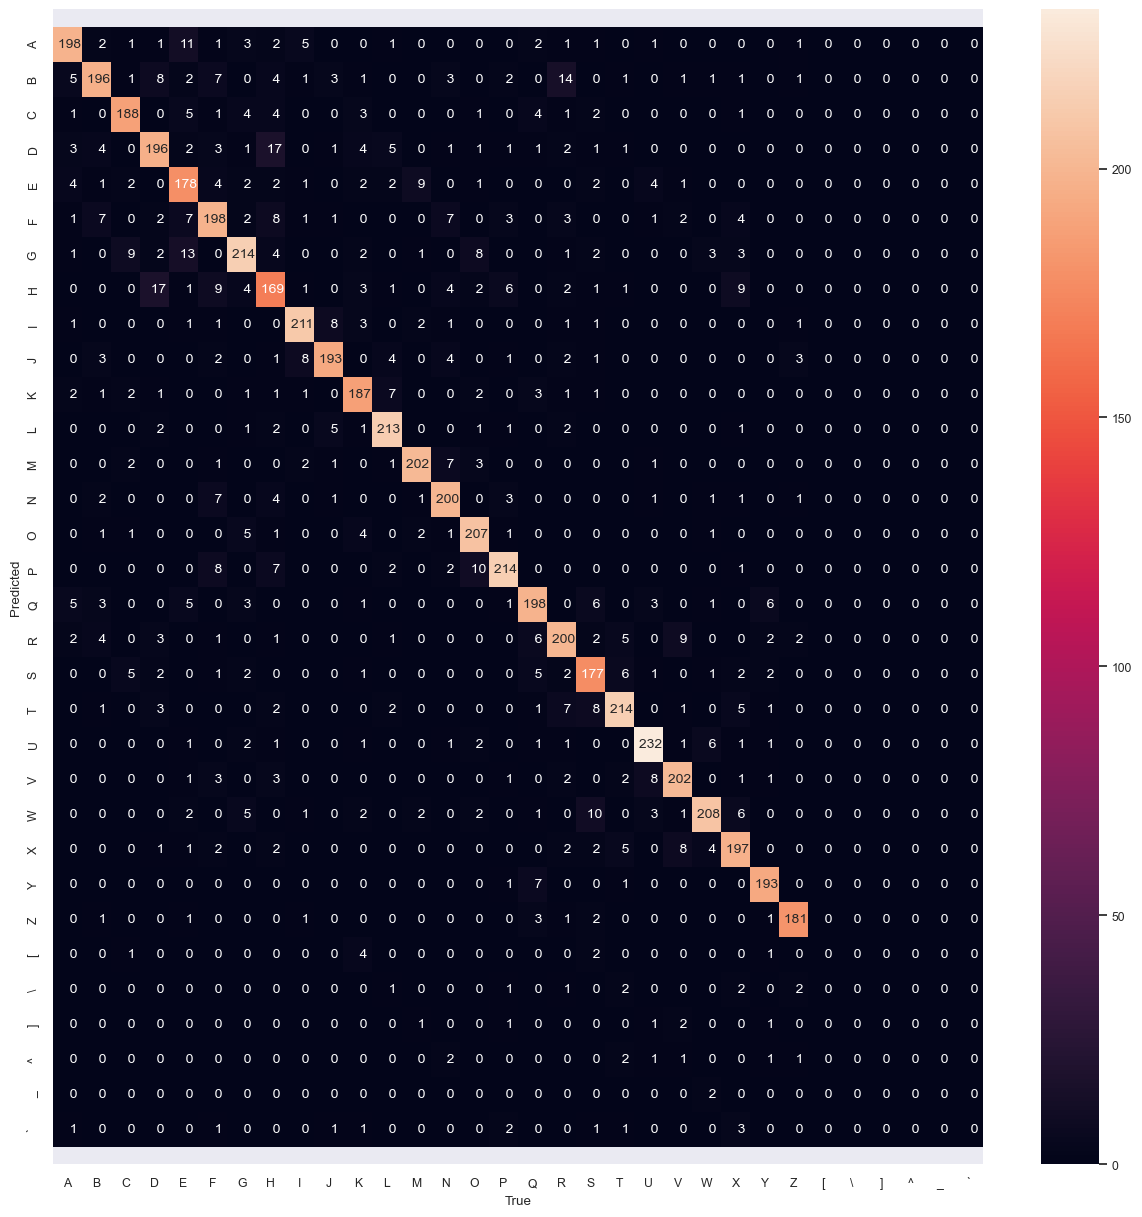

In [10]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate list of true-predicted letter codes
true= [to_letter_code(val) for val in testy]
pred= [to_letter_code(val) for val in NN_out]

# Generate confusion matrix
CM= confusion_matrix(pred,true)

# Plot heatmap
df_cm = pd.DataFrame(CM, range(32), range(32))
t_labels= [ chr(val+65) for val in range(0,32)]

plt.figure(figsize=(15,15))

sn.set(font_scale=0.8) # for label size
HM= sn.heatmap(df_cm, annot=True, annot_kws={"size":10}, fmt="4d")
HM.set_yticklabels(t_labels)
HM.set_xticklabels(t_labels)

# Patch to avoid cut in top/bottom; see https://github.com/mwaskom/seaborn/issues/1773
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# Here we use some modifications to extract interpretable results to compare with the results obtained via WEKA

# 1. Mean Absolute Error ~ 0.3  
WEKA MAE ~ 0.4

In [17]:

n = 20000
sum = 0
  
# for loop for iteration
for i in range(len(true)):
    sum += abs(true[i] - pred[i])
  
error = sum/n
  
# display
print("Mean absolute error : " + str(error))

Mean absolute error : 0.2818


# 2. Root Mean Squared Error ~ 0.5

WEKA RMSE ~ 0.6

In [25]:
import math
from sklearn.metrics import mean_squared_error
from math import sqrt

I=sqrt(mean_squared_error(true, pred)) 

n = 20000
sum = 0
  
# for loop for iteration
for i in range(len(true)):
    sum += ((true[i] - pred[i])*(true[i] - pred[i]))
  
error = sqrt(sum/n)/I
  
# display
print("Root Mean squared error : " + str(error))

Root Mean squared error : 0.5477225575051662


# 3. Correlation Coefficient : 

# 3.1 Spearman Correlation Coefficient ~ 0.91
Weka CC ~ 0.9

In [34]:
import scipy
er, p = scipy.stats.spearmanr(true, pred) 
# display
print("Spearman Correlation Coefficient : " + str(er))

Spearman Correlation Coefficient : 0.9099327547845509


# 3.2 Pearson Correlation Coefficient ~ 0.91
Weka CC ~ 0.9

In [35]:
er, p = scipy.stats.pearsonr(true, pred)
# display
print("Pearson Correlation Coefficient : " + str(er))

Pearson Correlation Coefficient : 0.906412432412239


# Root Relative Squared Error ~ 0.31 
# RRSE ~ 31 %
WEKA RRSE ~ 39 %

# IN GOOD AGREEMENT WITH WEKA RESULT

In [46]:
# Root Relative Squared Error


import math
from sklearn.metrics import mean_squared_error
from math import sqrt

I=sqrt(mean_squared_error(true, pred)) 
J = mean_squared_error(true, pred)
  
err = I/J
  
# display
print("Root Mean squared error : " + str(err))

Root Mean squared error : 0.3083425195077314


# Relative Absolute Error ~ 0.13
# RAE ~ 13 %
WEKA RAE ~ 34 %

# SEEMS BETTER THAN WEKA RESULT; SUSPICIOUS!!

In [69]:
#RELATIVE ABSOLUTE ERROR: RAE is defined as the ratio between the sum of absolute errors and the sum of absolute deviations

maer=statistics.mean(pred)
n = 20000
sum = 0
  
# for loop for iteration
for i in range(len(true)):
    sum += abs(true[i] - pred[i])

    sum1 = sum

for j in range(len(true)):
    sum += abs(true[j] - maer)

    sum2 = sum   

errorrr = sum1/sum2
  
# display
print("Mean absolute error : " + str(errorrr))

Mean absolute error : 0.12740539087262648


# A Comprehensive PLOT of all possible Regression Metrics :

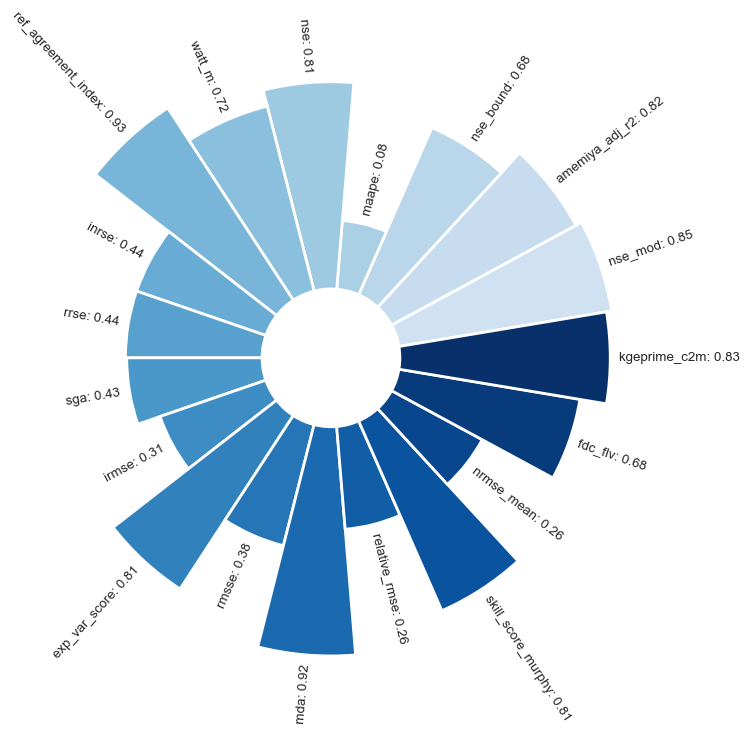

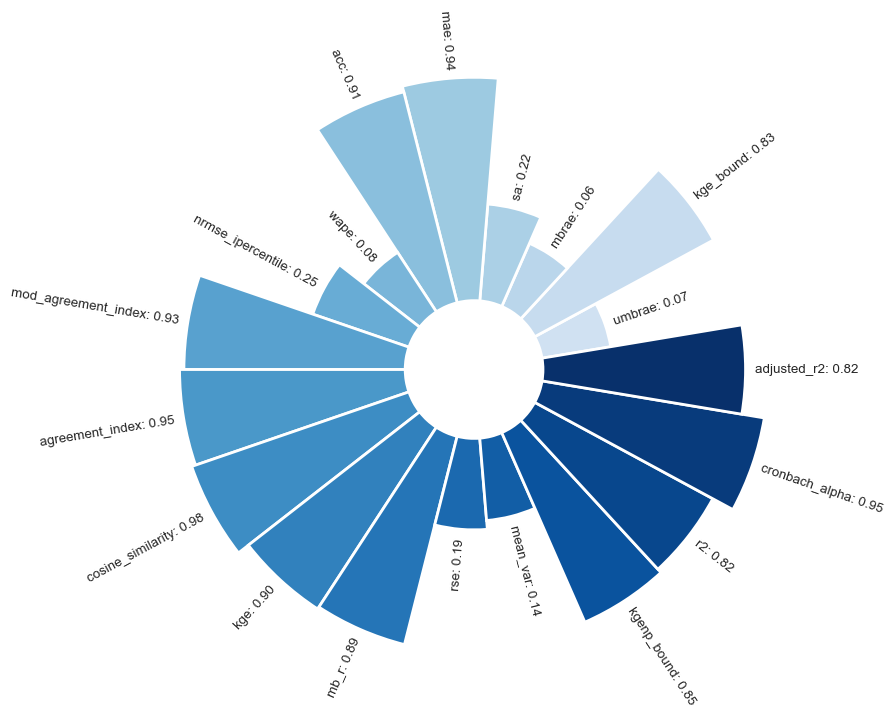

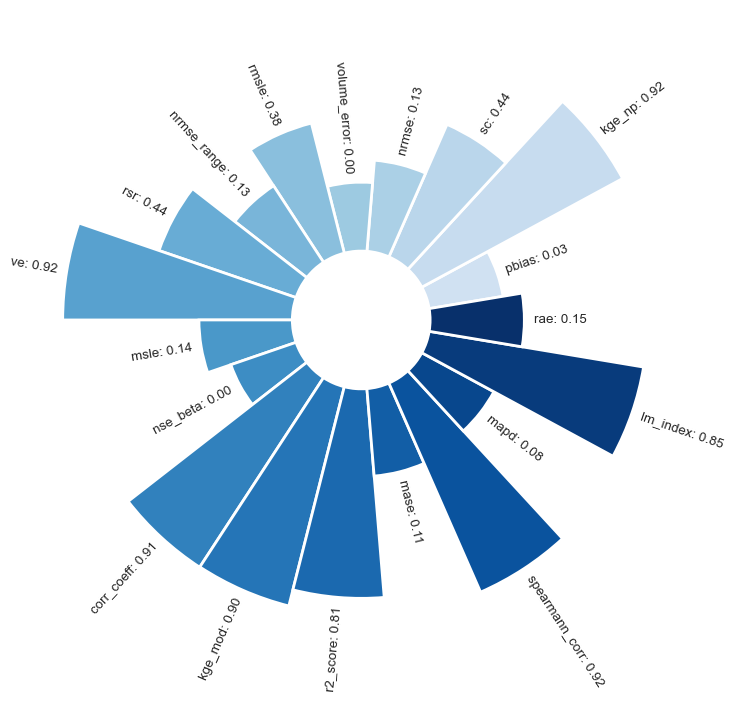

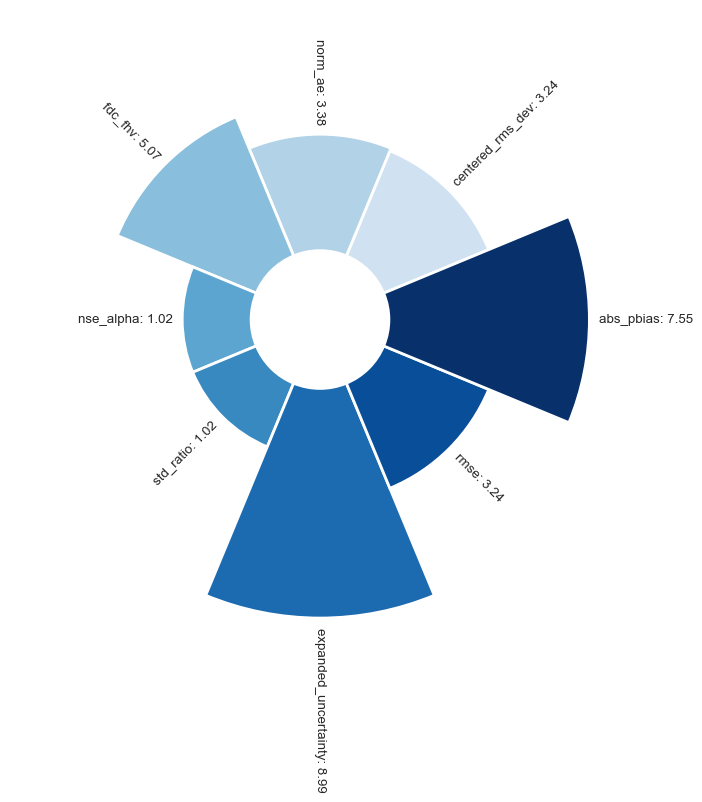

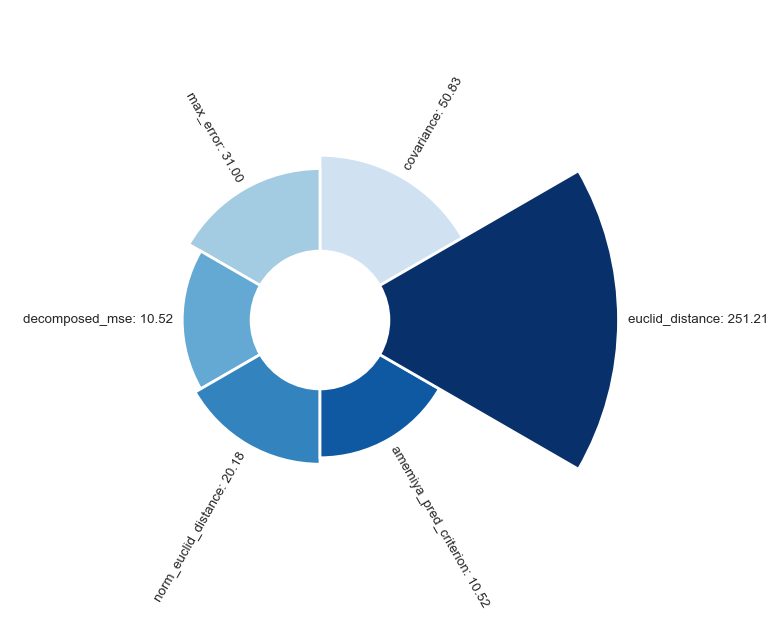

In [15]:
import numpy as np
from SeqMetrics import RegressionMetrics, plot_metrics

er = RegressionMetrics(true, pred)

plot_metrics(er.calculate_all(),  color="Blues")